**Note** -


1.   Scores mentioned in this notebook may vary because when a CCN model is getting initialized random weights are assigned everytime
2.   Model is scripted assuming dataset would be reading the data from google drive
3.   Base model findings whether overfitting/Underfitting varies eachtime, in this notebook avg is taken and findings are mentioned



In [1]:
import pathlib
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


**Update the Dataset path here**

In [3]:
!unzip /content/gdrive/My\ Drive/DeepLearning/DeepLearningCaseStudy/CNN_assignment.zip
!ls
!pwd

Archive:  /content/gdrive/My Drive/DeepLearning/DeepLearningCaseStudy/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic kera

In [4]:
#import pathlib

# Update the file path without escape characters
filePath = r"/content/Skin cancer ISIC The International Skin Imaging Collaboration"

# Define the paths for train and test datasets
data_dir_train = pathlib.Path(filePath + "/Train/")
data_dir_test = pathlib.Path(filePath + "/Test/")

# Check the paths and the number of images in each dataset
#print(data_dir_train)
#print(data_dir_test)

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of images in the train dataset:", image_count_train)

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of images in the test dataset:", image_count_test)

Number of images in the train dataset: 2239
Number of images in the test dataset: 118


Creating a DataSet

In [5]:
# Define the image dimensions
img_width, img_height = 180, 180
batch_size = 32

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
train_ds_copy = train_ds

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:

# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize One instance for all classes

In [9]:
import matplotlib.pyplot as plt

{'actinic keratosis': False, 'basal cell carcinoma': False, 'dermatofibroma': False, 'melanoma': False, 'nevus': False, 'pigmented benign keratosis': False, 'seborrheic keratosis': False, 'squamous cell carcinoma': False, 'vascular lesion': False}


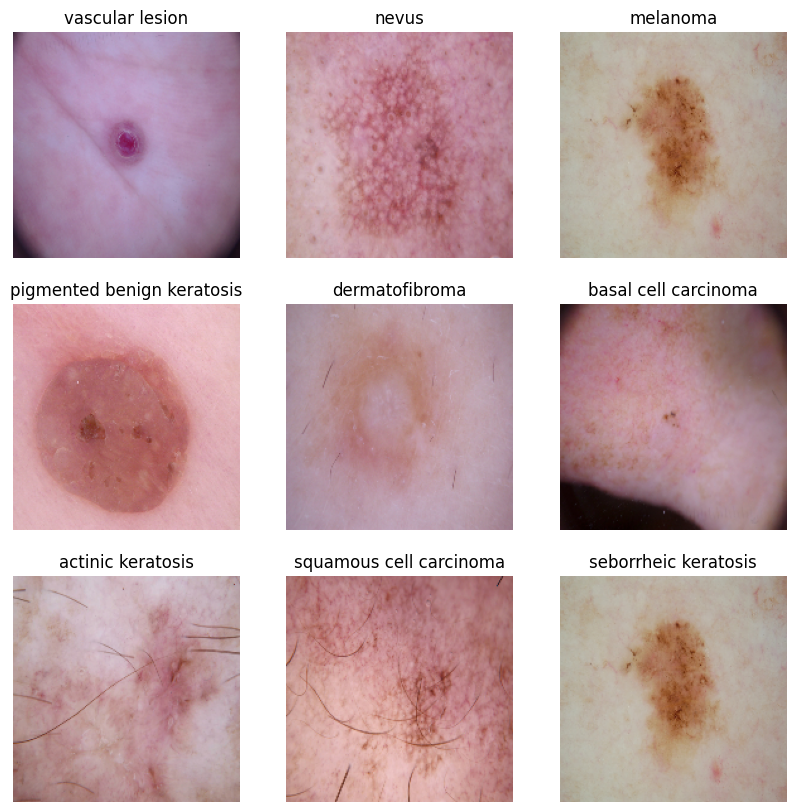

In [10]:
plt.figure(figsize=(10, 10))

# Dictionary to store whether a class image has been shown or not
class_shown = {class_name: False for class_name in class_names}
print((class_shown))
j=1
for images, labels in train_ds:
    for i in range(len(images)):
        label = class_names[labels[i]]
        if not class_shown[label]:
            #print("i Value",i)
            #print("Length of class_shown",len(class_shown))
            ax = plt.subplot(3, 3, j)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(label)
            plt.axis("off")
            j=j+1
            class_shown[label] = True
            break  # Move to the next class once an image is shown for the current class

    # Check if all classes have been shown
    if all(class_shown.values()):
        break

plt.show()

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model Building and Training

In [12]:
# Normalize pixel values between (0, 1)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3))


#model = keras.Sequential([
    #keras.layers.Dense(132, activation=tf.nn.relu, input_shape=(img_width,img_height)),
    #keras.layers.Dense(132, activation=tf.nn.relu),
    #keras.layers.Dense(132, activation=tf.nn.relu),
    #keras.layers.Dense(10, activation=tf.nn.softmax)])

In [13]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [14]:
# model architecture
model = Sequential()
#model.add(normalization_layer)
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(img_height, img_width,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))


In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Normalizing the input image
#train_ds /= 255
#x_test /= 255


In [16]:
# summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 89, 89, 64)        18496     
                                                        

In [17]:
epochs = 20
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 36s 165ms/step - loss: 57.2164 - accuracy: 0.2327 - val_loss: 2.0774 - val_accuracy: 0.2148
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: 2.1606 - accuracy: 0.2171 - val_loss: 2.1451 - val_accuracy: 0.2103
Epoch 3/20
56/56 [==============================] - 4s 69ms/step - loss: 2.1180 - accuracy: 0.2193 - val_loss: 2.1243 - val_accuracy: 0.2081
Epoch 4/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0401 - accuracy: 0.2360 - val_loss: 2.0727 - val_accuracy: 0.2081
Epoch 5/20
56/56 [==============================] - 4s 69ms/step - loss: 1.9790 - accuracy: 0.2394 - val_loss: 2.0346 - val_accuracy: 0.2103
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 2.9667 - accuracy: 0.2260 - val_loss: 2.0282 - val_accuracy: 0.1991
Epoch 7/20
56/56 [==============================] - 4s 70ms/step - loss: 3.1722 - accuracy: 0.2137 - val_loss: 2.0543 - val_accuracy: 0.1946
Epoch 8/20

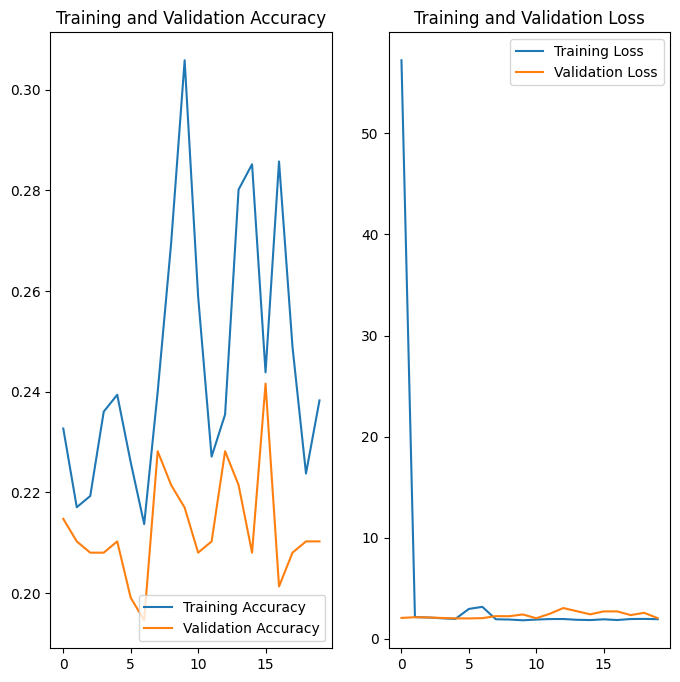

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

By seeing the above graphs, it is clear that the model is Underfitting, in this segment of data.

**Findings:**



1.   **Model is Underfitting i.e. Model is performing very bad with the training data as well as validation data with accuracy of ~23% and ~21%





**Note:** Many times when building the model, model performance was overfitting as well with acuuracy score of ~82% on training dataset and accuracy score of ~22% in validation data set, Either Overfitting/Underfitting below data agumentaion technique helped us to get rid of both the cases

**Applying Data Augumentation**

In [19]:
data_aug=keras.Sequential([
                           layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                           layers.experimental.preprocessing.RandomRotation(0.2,fill_mode='reflect'),
                           layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3),width_factor=(0.2,0.3),fill_mode='reflect')])


{'actinic keratosis': False, 'basal cell carcinoma': False, 'dermatofibroma': False, 'melanoma': False, 'nevus': False, 'pigmented benign keratosis': False, 'seborrheic keratosis': False, 'squamous cell carcinoma': False, 'vascular lesion': False}


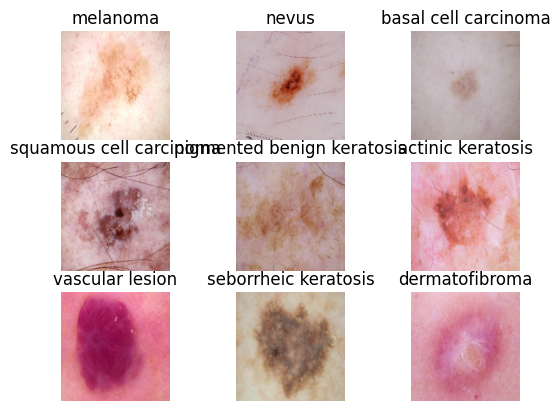

In [20]:
'''
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
'''
# Dictionary to store whether a class image has been shown or not
class_shown_new = {class_name: False for class_name in class_names}
print((class_shown_new))
j=1
for images, labels in train_ds:
    for i in range(len(images)):
        label = class_names[labels[i]]
        if not class_shown_new[label]:
            #print("i Value",i)
            #print("Length of class_shown_new",len(class_shown_new))
            ax = plt.subplot(3, 3, j)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(label)
            plt.axis("off")
            j=j+1
            class_shown_new[label] = True
            break  # Move to the next class once an image is shown for the current class

    # Check if all classes have been shown
    if all(class_shown_new.values()):
        break

plt.show()

In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 12s 113ms/step - loss: 2.0432 - accuracy: 0.1998 - val_loss: 2.0167 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 5s 89ms/step - loss: 1.9567 - accuracy: 0.2533 - val_loss: 2.0306 - val_accuracy: 0.2013
Epoch 3/20
56/56 [==============================] - 5s 89ms/step - loss: 1.9568 - accuracy: 0.2589 - val_loss: 2.0134 - val_accuracy: 0.2394
Epoch 4/20
56/56 [==============================] - 5s 89ms/step - loss: 1.8580 - accuracy: 0.3181 - val_loss: 1.8350 - val_accuracy: 0.3557
Epoch 5/20
56/56 [==============================] - 5s 88ms/step - loss: 1.7462 - accuracy: 0.3728 - val_loss: 1.7297 - val_accuracy: 0.3803
Epoch 6/20
56/56 [==============================] - 5s 91ms/step - loss: 1.6753 - accuracy: 0.3806 - val_loss: 1.6826 - val_accuracy: 0.3691
Epoch 7/20
56/56 [==============================] - 5s 88ms/step - loss: 1.6933 - accuracy: 0.3890 - val_loss: 1.5927 - val_accuracy: 0.4318
Epoch 8/20
56/56 [====

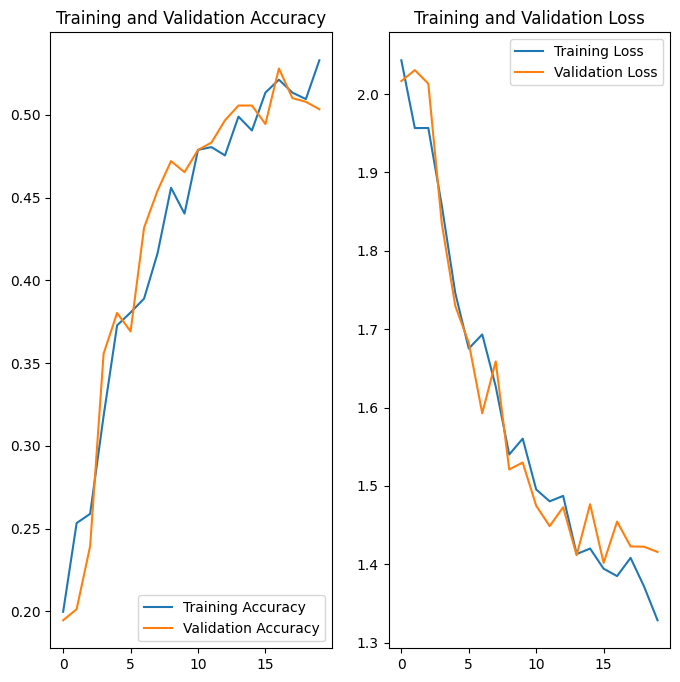

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After applying data augumentation, we see that the overfitting/Underfitting is fadded away

In [25]:

path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)

In [26]:

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


<BarContainer object of 9 artists>

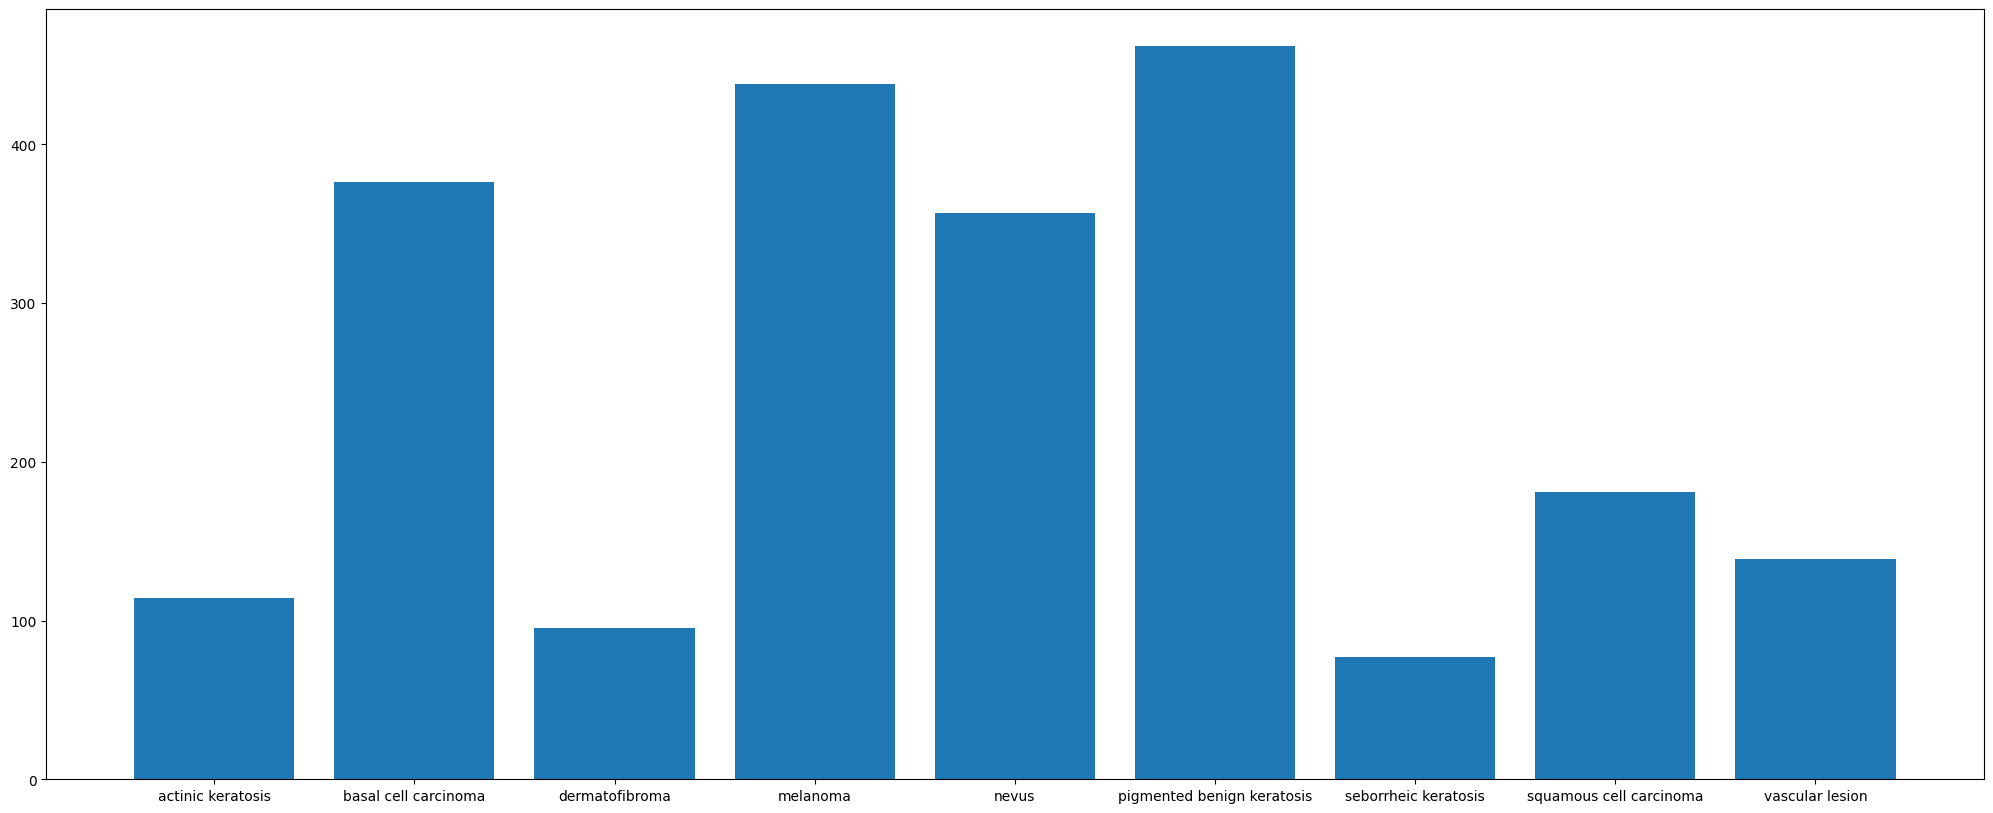

In [27]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [28]:
# Set the path to the root directory of your dataset
dataset_path = data_dir_train

# Get the list of class names based on the subdirectories in the dataset path
class_names = sorted(os.listdir(dataset_path))

# Dictionary to store the count of images in each class
class_counts = {class_name: 0 for class_name in class_names}

# Loop through each class directory and count the images in it
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    class_images = os.listdir(class_dir)
    class_counts[class_name] = len(class_images)

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"Class {class_name}: {count} images")


Class actinic keratosis: 114 images
Class basal cell carcinoma: 376 images
Class dermatofibroma: 95 images
Class melanoma: 438 images
Class nevus: 357 images
Class pigmented benign keratosis: 462 images
Class seborrheic keratosis: 77 images
Class squamous cell carcinoma: 181 images
Class vascular lesion: 139 images


From the above count, we can clearly see that data is not evenly distributed across the classes and there is clearly a Class Imbalance in this dataset.

**Findings**

1.   Seborrheic keratosis is having the lowest distribution
2.   Pigmented Benign keratosis is having the highest distribution of data





***Rectify the class imbalance***

In [29]:
!pip install Augmentor

In [30]:

path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791440137A90>: 100%|██████████| 500/500 [00:15<00:00, 31.70 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79142FFAF490>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79144012B9A0>: 100%|██████████| 500/500 [00:19<00:00, 25.99 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79142FF14700>: 100%|██████████| 500/500 [01:17<00:00,  6.41 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x791440187F70>: 100%|██████████| 500/500 [01:02<00:00,  8.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7914401357B0>: 100%|██████████| 500/500 [00:14<00:00, 33.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x79142FFD7850>: 100%|██████████| 500/500 [00:35<00:00, 14.00 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79144012BC70>: 100%|██████████| 500/500 [00:16<00:00, 29.80 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79142FF80490>: 100%|██████████| 500/500 [00:14<00:00, 33.55 Samples/s]


In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [32]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [33]:

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [34]:

path_list_new=path_list
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-35-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

After applying the agumentation class and creating new training examples from the existing ones, we see that the class imbalance is handled

In [37]:

batch_size = 32
img_height = 180
img_width = 180

In [38]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [40]:
model = Sequential([
  data_aug,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.BatchNormalization(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])



In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
epochs=40
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 50s 244ms/step - loss: 1.7121 - accuracy: 0.3986 - val_loss: 4.0813 - val_accuracy: 0.1418
Epoch 2/40
169/169 [==============================] - 30s 171ms/step - loss: 1.3193 - accuracy: 0.4955 - val_loss: 1.6306 - val_accuracy: 0.4076
Epoch 3/40
169/169 [==============================] - 29s 169ms/step - loss: 1.2363 - accuracy: 0.5360 - val_loss: 1.2980 - val_accuracy: 0.4959
Epoch 4/40
169/169 [==============================] - 31s 179ms/step - loss: 1.1802 - accuracy: 0.5503 - val_loss: 1.2322 - val_accuracy: 0.5390
Epoch 5/40
169/169 [==============================] - 30s 172ms/step - loss: 1.0914 - accuracy: 0.5810 - val_loss: 1.2338 - val_accuracy: 0.5635
Epoch 6/40
169/169 [==============================] - 30s 170ms/step - loss: 1.0456 - accuracy: 0.5968 - val_loss: 1.0358 - val_accuracy: 0.6140
Epoch 7/40
169/169 [==============================] - 35s 204ms/step - loss: 0.9701 - accuracy: 0.6246 - val_loss: 1.1029 - val_accuracy: 0.5

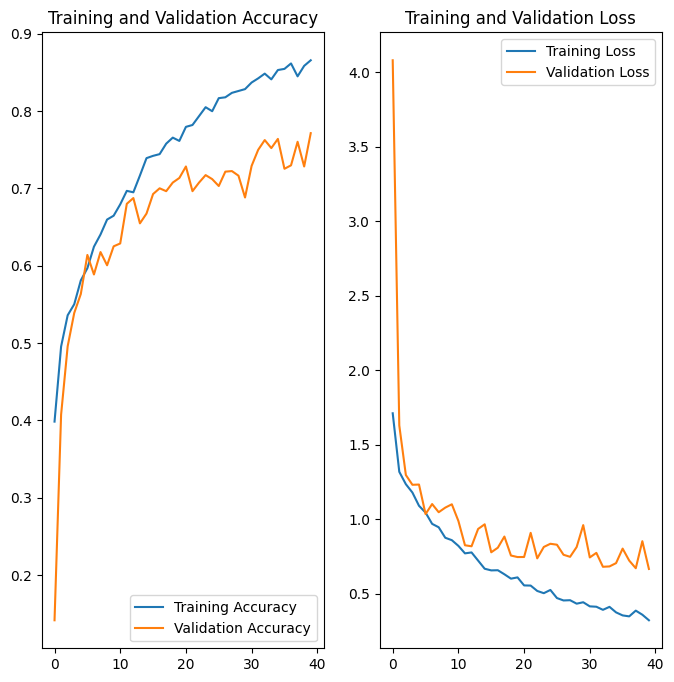

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**ACCURACY='86%' VALLIDATION_ACCURACY='77%'**


 and due to  

*   The model is neither overfitting nor underfitting
*   Agumentation and class rebalance helped model to boost its accuracy